In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
import phylovelo as pv
from scipy.stats import spearmanr
from Bio import Phylo
import scvelo as scv
import loompy

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plt.rcParams['font.size']=12
data_path = '/data3/wangkun/phylovelo_datasets/emt/'

In [3]:
adata = scv.read(data_path+"combined.loom",cache=False)
sample1 = pd.read_csv(data_path+"scRNA_raw_counts.csv",sep=',',header=0,index_col=0)
sample1_metadata = pd.read_csv(data_path+"scRNA_metadata.csv",sep=',',header=0,index_col=0)
cells = sample1.columns.to_list()
cells = [i.replace("-1","x").replace("PT_","SRR14436657:").replace("PTab_","SRR14436659:").replace("Met_","SRR14436661:").replace("Liver_","SRR14436663:").replace("Lung_","SRR14436665:").replace("Blood_","SRR14436667:") for i in cells]
sample1_adata = adata[cells,:]
sample1_adata.obs["emt_pseudotime"] = sample1_metadata["pseudotime"].to_list()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
scv.pp.filter_and_normalize(sample1_adata,min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(sample1_adata,n_pcs=30, n_neighbors=30)  #calculate the first and second order moments
scv.tl.louvain(sample1_adata)
# scv.tl.umap(sample1_adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 24837 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
umap = pd.read_csv(data_path+'umap.csv', index_col=0)
sample1_adata.obsm['X_umap'] = umap.loc[sample1_adata.obs_names].to_numpy()

recovering dynamics (using 10/160 cores)


  0%|          | 0/975 [00:00<?, ?gene/s]

    finished (0:01:59) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/160 cores)


  0%|          | 0/601 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


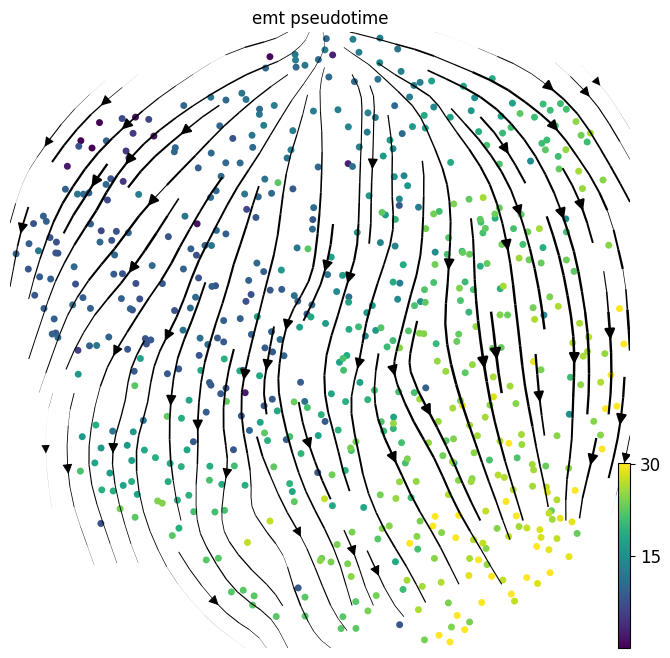

In [7]:
scv.tl.recover_dynamics(sample1_adata,n_jobs=10)
scv.tl.velocity(sample1_adata,mode="dynamical")
scv.tl.velocity_graph(sample1_adata)
scv.pl.velocity_embedding_stream(sample1_adata, basis='X_umap',color="emt_pseudotime",figsize=[8, 8],s=100,alpha=1,density=1,arrow_size=1.5,smooth=1)

In [7]:
x_normed = adata[cells,:]
scv.pp.filter_and_normalize(x_normed, min_shared_counts=10)

tree = Phylo.read(data_path+'emt_collapsed.nwk', 'newick')
count = adata[cells,:]

sd = pv.scData()
sd.phylo_tree = tree
sd.cell_names = cells
sd.count = pd.DataFrame(data=count.X.A, columns=count.var_names, index=cells)
sd.Xdr = pd.DataFrame(data=sample1_adata.obsm['X_umap'], index=sample1_adata.obs_names)
sd.Xdr = sd.Xdr.loc[cells]
scv.pp.filter_and_normalize(count, min_shared_counts=10)
sd.x_normed = pd.DataFrame(data=count.X.A, columns=count.var_names, index=cells)


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


Filtered out 23686 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 23686 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [17]:
name_id_map = pd.DataFrame(data=[f'N{i}' for i in sample1_metadata['index']], index=[re.findall('(?<=\_)[AGCT]+(?=-)', i)[0] for i in sample1_metadata.index])
depths = [sd.phylo_tree.depths()[sd.phylo_tree.find_any(name=name_id_map.loc[re.findall('(?<=\:)[AGCT]+(?=x)', i)[0]].to_numpy()[0])] for i in sd.x_normed.index]

  0%|          | 0/10773 [00:00<?, ?it/s]

In [14]:
pv.velocity_inference(sd, depths, cutoff=0.95, target='x_normed')
pv.velocity_embedding(sd, target='x_normed')

  0%|          | 0/8599 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

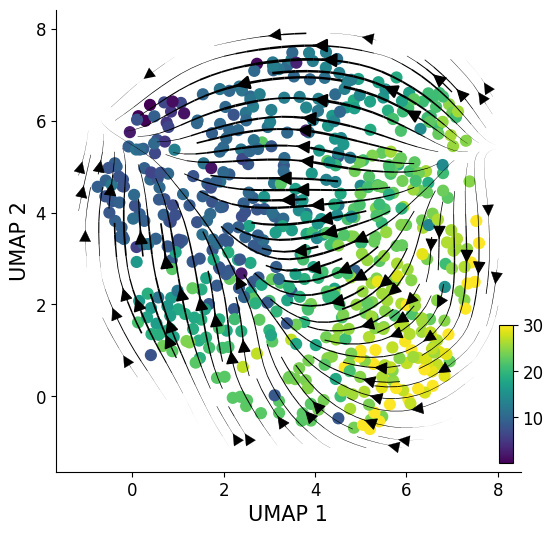

In [15]:
fig, ax = plt.subplots()
scatter=ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=60, c=sample1_adata.obs["emt_pseudotime"])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, radius=0.8, lw_coef=3000, arrowsize=2)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')

# plt.savefig('./figures/EMT/EMT_stream.pdf', dpi='figure', format='pdf')

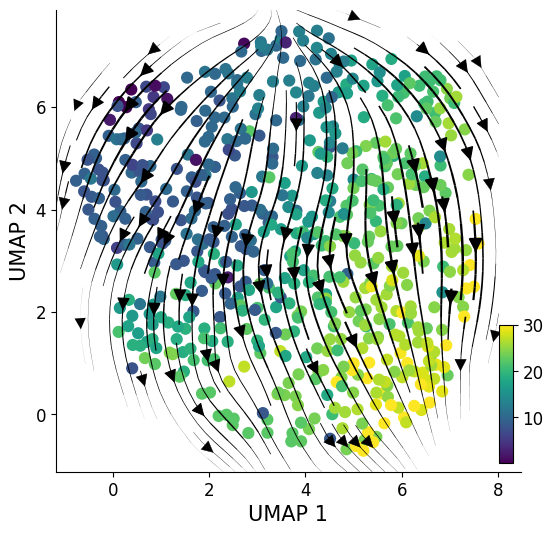

In [8]:
fig, ax = plt.subplots()
scatter=ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=60, c=sample1_adata.obs["emt_pseudotime"])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sample1_adata.obsm['velocity_umap'], ax, 'stream',streamdensity=1.2, radius=0.8, lw_coef=50, arrowsize=2)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')

# plt.savefig('./figures/EMT/EMT_stream.pdf', dpi='figure', format='pdf')

In [16]:
pv.calc_phylo_pseudotime(sd, n_neighbors=30)
scv.tl.latent_time(sample1_adata)

  0%|          | 0/600 [00:00<?, ?it/s]

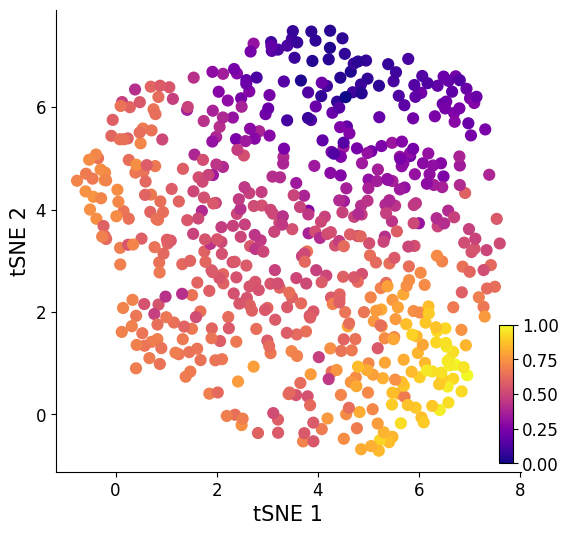

In [14]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(6, 6)
scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=60, c=sample1_adata.obs["latent_time"],cmap='plasma')
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')

# plt.savefig('./figures/EMT/latent_time.pdf', dpi='figure', format='pdf')

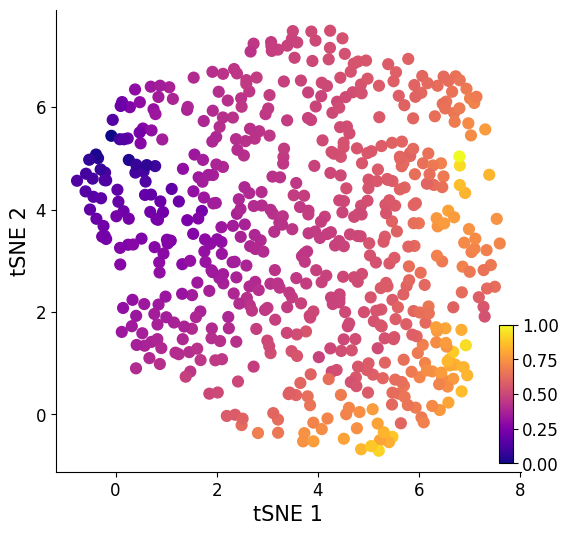

In [16]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(6, 6)
scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=60, c=sd.phylo_pseudotime,cmap='plasma')
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')

# plt.savefig('./figures/EMT/phylo_pseudotime.pdf', dpi='figure', format='pdf')

In [21]:
from copy import deepcopy
sd_shuffle = deepcopy(sd)
np.random.shuffle(depths)
pv.velocity_inference(sd_shuffle, depths, cutoff=0.95, target='x_normed')
v_megs = pd.DataFrame(data=sd_shuffle.velocity, index=sd_shuffle.x_normed.columns, columns=['velocity']).loc[sd_shuffle.megs]
v_megs['p_value']=sd_shuffle.pvals.T
v_megs['q_value']=sd_shuffle.qvals.T
v_megs.to_csv('./megs/KPCY_shuffle.csv')

  0%|          | 0/8599 [00:00<?, ?it/s]

In [8]:
import scanpy as sc
import anndata as ad

adata_gs = ad.AnnData(sd.count)
adata_gs.var_names_make_unique()
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2','USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']
g2m_genes= ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
s_genes = [i.lower().capitalize() for i in s_genes]
g2m_genes = [i.lower().capitalize() for i in g2m_genes]
sc.tl.score_genes_cell_cycle(adata_gs, s_genes=s_genes, g2m_genes=g2m_genes)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
sc.pp.filter_genes(adata_gs, min_counts=20)
sc.pp.normalize_total(adata_gs, inplace=True)
sc.pp.log1p(adata_gs)
sc.pp.regress_out(adata_gs, ['S_score', 'G2M_score'])
sc.tl.pca(adata_gs)
sc.tl.tsne(adata_gs)

... storing 'phase' as categorical


In [21]:
sc.pp.neighbors(adata_gs)
sc.tl.umap(adata_gs)

In [11]:
sd_regcc = pv.scData(x_normed=pd.DataFrame(adata_gs.X, index=adata_gs.obs_names, columns=adata_gs.var_names),
                      Xdr=pd.DataFrame(adata_gs.obsm['X_tsne'],index=adata_gs.obs_names)
                     )

In [12]:
pv.velocity_inference(sd_regcc, depths, cutoff=0.97, target='x_normed')
pv.velocity_embedding(sd_regcc, target='x_normed')
pv.calc_phylo_pseudotime(sd_regcc, 30, 0.3)

  0%|          | 0/10773 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

In [22]:
sd_regcc.Xdr = pd.DataFrame(adata_gs.obsm['X_umap'],index=adata_gs.obs_names)
pv.velocity_embedding(sd_regcc, target='x_normed')

  0%|          | 0/601 [00:00<?, ?it/s]

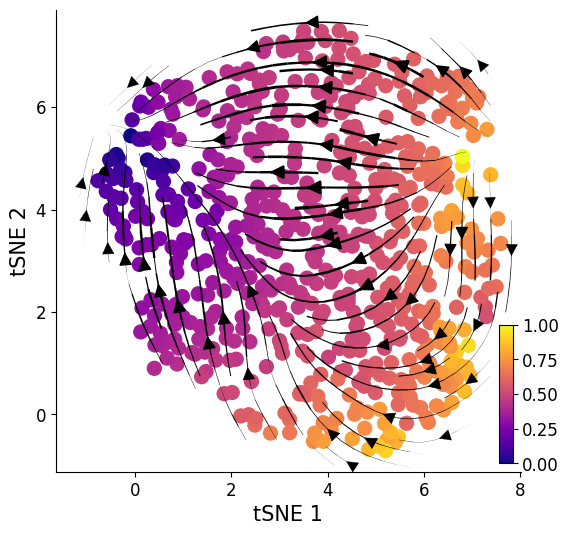

In [36]:
fig, ax = plt.subplots()
scatter=ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=100, c=sd.phylo_pseudotime,cmap='plasma')
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream', streamdensity=1, radius=0.5, lw_coef=5000, arrowsize=2)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('./figures/fig6/A549_stream.pdf')

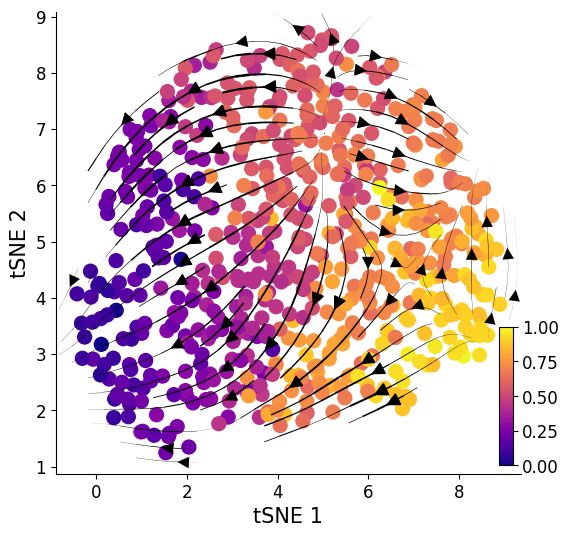

In [33]:
fig, ax = plt.subplots()
scatter=ax.scatter(sd_regcc.Xdr.iloc[:,0], sd_regcc.Xdr.iloc[:,1], s=100, c=sd_regcc.phylo_pseudotime,cmap='plasma')
ax = pv.velocity_plot(sd_regcc.Xdr.to_numpy(), sd_regcc.velocity_embeded, ax, 'stream', streamdensity=1, radius=0.5, lw_coef=5000, arrowsize=2)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('./figures/fig6/A549_stream.pdf')

<AxesSubplot: >

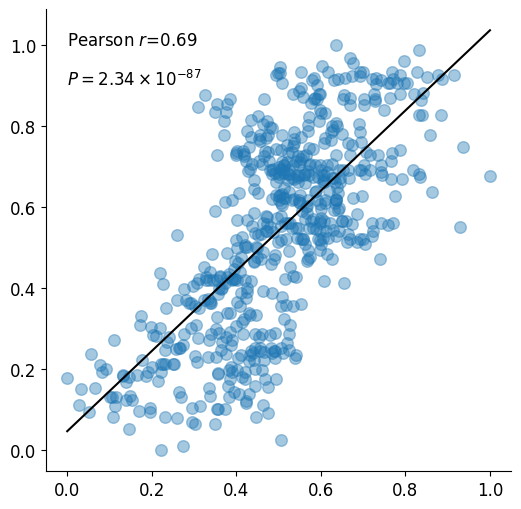

In [35]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(6, 6)
pv.corr_plot(sd.phylo_pseudotime, sd_regcc.phylo_pseudotime, ax, fontsize=12)
ax.set_xlabel('')

In [10]:
import scanpy as sc
import anndata as ad
adata = ad.AnnData(sd.count)
adata.var_names_make_unique()
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2','USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']
g2m_genes= ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
s_genes = [i.lower().capitalize() for i in s_genes]
g2m_genes = [i.lower().capitalize() for i in g2m_genes]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Text(0.5, 0, 'G2M score')

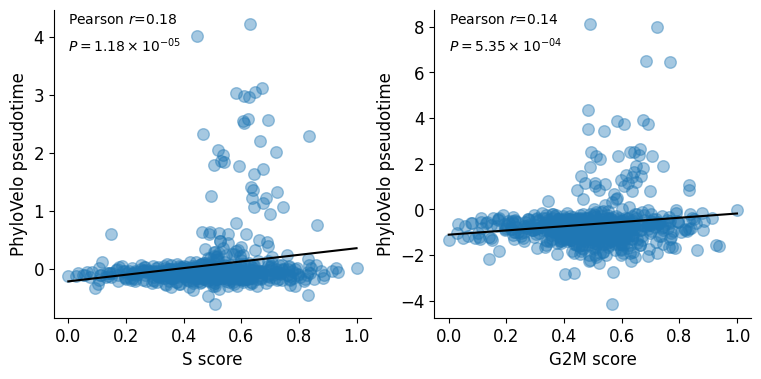

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))
pv.corr_plot(sd.phylo_pseudotime, adata[sd.count.index].obs['S_score'], ax[0])
pv.corr_plot(sd.phylo_pseudotime, adata[sd.count.index].obs['G2M_score'], ax[1])
ax[0].set_ylabel('PhyloVelo pseudotime')
ax[1].set_ylabel('PhyloVelo pseudotime')
ax[0].set_xlabel('S score')
ax[1].set_xlabel('G2M score')

Text(0.5, 0, 'G2M score')

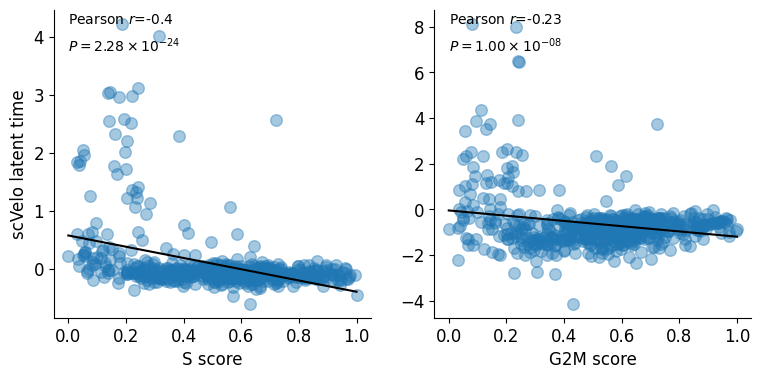

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))
pv.corr_plot(sample1_adata[sd.count.index].obs['latent_time'], adata[sd.count.index].obs['S_score'], ax[0])
pv.corr_plot(sample1_adata[sd.count.index].obs['latent_time'], adata[sd.count.index].obs['G2M_score'], ax[1])
ax[0].set_ylabel('scVelo latent time')
ax[0].set_xlabel('S score')
ax[1].set_xlabel('G2M score')

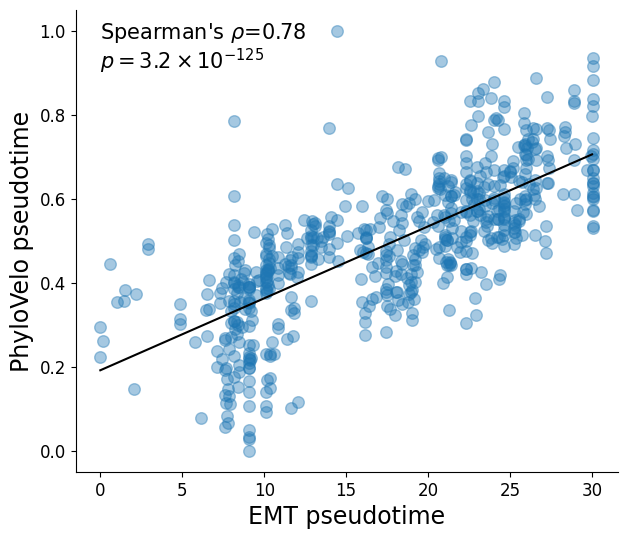

In [25]:

x = sample1_adata.obs["emt_pseudotime"]
y = sd.phylo_pseudotime

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(0,30,60) + b

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(0,30,60), y_est, '-', c='k')
ax.set_xlabel('EMT pseudotime', fontsize=17)
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
# ax.text(0, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(0, 0.98, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(0, 0.91, r'$p={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# plt.savefig('./figures/EMT/phylopseudotime_cmp.pdf', dpi='figure', format='pdf')


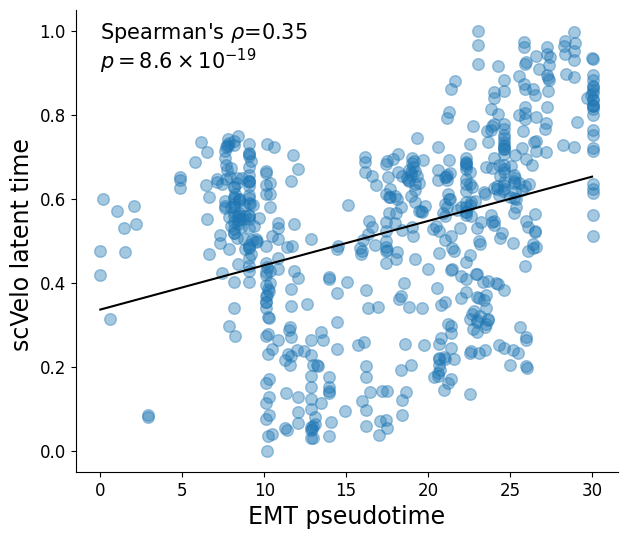

In [39]:

x = sample1_adata.obs["emt_pseudotime"]
y = sample1_adata.obs.latent_time

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(0,30,60) + b

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(0,30,60), y_est, '-', c='k')
ax.set_xlabel('EMT pseudotime', fontsize=17)
ax.set_ylabel('scVelo latent time ', fontsize=17)
rho, pval = spearmanr(x, y)
ax.text(0, 0.98, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(0, 0.91, r'$p={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# plt.savefig('./figures/EMT/latenttime_cmp.pdf', dpi='figure', format='pdf')
